# Exploration des donnees crypto BTC / ETH / SOL

Ce notebook presente une analyse exploratoire des donnees de marche pour trois cryptomonnaies majeures : **Bitcoin (BTC)**, **Ethereum (ETH)** et **Solana (SOL)**.

Les donnees proviennent de BigQuery et contiennent des chandeliers (OHLCV) enrichis avec des indicateurs techniques (RSI, MACD, Bollinger Bands, moyennes mobiles).

**Plan du notebook :**
1. Chargement et apercu des donnees
2. Qualite des donnees
3. Statistiques descriptives par crypto
4. Analyse temporelle (heures, jours)
5. Evolution des prix et performance comparee
6. Analyse technique detaillee (BTC)
7. Analyse des rendements et du risque
8. Correlations entre cryptos
9. Analyse des volumes
10. Nouveaux insights : regimes de volatilite, divergences volume-prix, beta rolling

---
## 1. Chargement et apercu des donnees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.cloud import bigquery
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

os.makedirs('images/exploratoire', exist_ok=True)

In [2]:
PROJET_ID="training-gcp-484513"

In [3]:
client = bigquery.Client(project=PROJET_ID)

In [4]:
query = """
SELECT *
FROM `crypto_analytics.market_data_unified`
WHERE symbol IN ('BTCUSDT', 'ETHUSDT', 'SOLUSDT')
ORDER BY timestamp DESC
"""

In [5]:
df = client.query(query).to_dataframe()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['ingestion_timestamp'] = pd.to_datetime(df['ingestion_timestamp'])

print(f"Dimensions : {df.shape[0]} lignes x {df.shape[1]} colonnes")
print(f"Cryptomonnaies : {df['symbol'].unique()}")
print(f"Periode : {df['timestamp'].min()} -> {df['timestamp'].max()}")
print(f"Duree : {(df['timestamp'].max() - df['timestamp'].min()).days} jours")

Dimensions : 1866122 lignes x 21 colonnes
Cryptomonnaies : ['SOLUSDT' 'ETHUSDT' 'BTCUSDT']
Periode : 2020-01-01 00:00:00+00:00 -> 2026-02-13 23:15:00+00:00
Duree : 2235 jours


In [6]:
df.head(10)

,timestamp,date,hour,day_of_week,symbol,open,high,low,close,volume,...,sma_20,ema_50,rsi_14,macd,macd_signal,bb_upper,bb_middle,bb_lower,source,ingestion_timestamp
0,2026-02-13 23:15:00+00:00,2026-02-13,23,Friday,SOLUSDT,84.39,84.52,84.24,84.26,7738.93600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:25:06.817233+00:00
1,2026-02-13 23:15:00+00:00,2026-02-13,23,Friday,ETHUSDT,2051.56,2053.87,2050.00,2051.30,621.28090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:25:06.826083+00:00
2,2026-02-13 23:15:00+00:00,2026-02-13,23,Friday,BTCUSDT,68924.24,68991.25,68896.00,68896.01,32.31309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:25:06.776709+00:00
3,2026-02-13 23:10:00+00:00,2026-02-13,23,Friday,BTCUSDT,68941.22,68970.00,68917.08,68924.24,7.47112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:20:04.667390+00:00
4,2026-02-13 23:10:00+00:00,2026-02-13,23,Friday,ETHUSDT,2051.35,2052.58,2050.71,2051.56,218.26780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:20:04.653743+00:00
5,2026-02-13 23:10:00+00:00,2026-02-13,23,Friday,SOLUSDT,84.38,84.43,84.36,84.38,3127.14700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:20:04.619424+00:00
6,2026-02-13 23:05:00+00:00,2026-02-13,23,Friday,SOLUSDT,84.53,84.53,84.34,84.39,10571.14400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:15:08.582211+00:00
7,2026-02-13 23:05:00+00:00,2026-02-13,23,Friday,BTCUSDT,68995.60,68995.60,68841.76,68941.21,43.09687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:15:08.537513+00:00
8,2026-02-13 23:05:00+00:00,2026-02-13,23,Friday,ETHUSDT,2054.40,2054.40,2049.32,2051.35,1557.68800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:15:08.594071+00:00
9,2026-02-13 23:00:00+00:00,2026-02-13,23,Friday,SOLUSDT,84.66,84.66,84.51,84.53,2771.29400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,streaming,2026-02-13 23:10:35.881260+00:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866122 entries, 0 to 1866121
Data columns (total 21 columns):
 #   Column               Dtype              
---  ------               -----              
 0   timestamp            datetime64[us, UTC]
 1   date                 dbdate             
 2   hour                 Int64              
 3   day_of_week          object             
 4   symbol               object             
 5   open                 float64            
 6   high                 float64            
 7   low                  float64            
 8   close                float64            
 9   volume               float64            
 10  trades               Int64              
 11  sma_20               float64            
 12  ema_50               float64            
 13  rsi_14               float64            
 14  macd                 float64            
 15  macd_signal          float64            
 16  bb_upper             float64            
 17  bb_middl

In [8]:
df.describe()

,hour,open,high,low,close,volume,trades,sma_20,ema_50,rsi_14,macd,macd_signal,bb_upper,bb_middle,bb_lower
count,1866122.0,1.866122e+06,1.866122e+06,1.866122e+06,1.866122e+06,1.866122e+06,1866122.0,1.865924e+06,1.865924e+06,1.865924e+06,1.865924e+06,1.865924e+06,1.865921e+06,1.865924e+06,1.865921e+06
mean,11.502907,1.729968e+04,1.731819e+04,1.728083e+04,1.729971e+04,5.599588e+03,5976.231863,1.729871e+04,1.729820e+04,5.031019e+01,2.392414e-01,2.386460e-01,1.738306e+04,1.729871e+04,1.721441e+04
std,6.922279,2.895200e+04,2.897829e+04,2.892522e+04,2.895202e+04,1.475124e+04,9284.79304,2.895122e+04,2.895063e+04,1.549496e+01,8.488557e+01,8.063501e+01,2.907541e+04,2.895122e+04,2.882772e+04
min,0.0,1.091000e+00,1.126000e+00,1.030100e+00,1.081500e+00,8.900000e-01,1.0,1.180095e+00,1.202668e+00,0.000000e+00,-2.917927e+03,-2.675795e+03,1.226378e+00,1.180095e+00,1.087586e+00
25%,6.0,1.594800e+02,1.597700e+02,1.591800e+02,1.594800e+02,2.142366e+02,1271.0,1.594915e+02,1.594637e+02,3.942260e+01,-2.292196e+00,-2.170666e+00,1.608378e+02,1.594915e+02,1.582068e+02
50%,12.0,2.342895e+03,2.346805e+03,2.338680e+03,2.342880e+03,1.154113e+03,2929.0,2.343483e+03,2.343319e+03,5.025641e+01,5.209936e-03,5.199145e-03,2.360545e+03,2.343483e+03,2.323807e+03
75%,18.0,2.384210e+04,2.387320e+04,2.381001e+04,2.384222e+04,5.139649e+03,6733.0,2.384121e+04,2.384292e+04,6.119104e+01,2.843462e+00,2.708554e+00,2.397922e+04,2.384121e+04,2.372871e+04
max,23.0,1.260112e+05,1.261996e+05,1.258681e+05,1.260112e+05,1.194228e+06,711259.0,1.255731e+05,1.254169e+05,1.000000e+02,2.911044e+03,2.553744e+03,1.260476e+05,1.255731e+05,1.251593e+05


---
## 2. Qualite des donnees

Avant toute analyse, on verifie la completude des donnees : valeurs manquantes, doublons et coherence des valeurs OHLCV.

In [9]:
# Valeurs manquantes
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Manquantes': missing,
    'Pourcentage (%)': missing_pct
})
missing_with_values = missing_df[missing_df['Manquantes'] > 0]

if missing_with_values.empty:
    print("Aucune valeur manquante.")
else:
    display(missing_with_values)

,Manquantes,Pourcentage (%)
sma_20,198,0.01
ema_50,198,0.01
rsi_14,198,0.01
macd,198,0.01
macd_signal,198,0.01
bb_upper,201,0.01
bb_middle,198,0.01
bb_lower,201,0.01


In [10]:
# Doublons
duplicates = df.duplicated().sum()
key_duplicates = df.duplicated(subset=['timestamp', 'symbol']).sum()
print(f"Doublons complets : {duplicates} ({duplicates/len(df)*100:.2f}%)")
print(f"Doublons (timestamp + symbol) : {key_duplicates}")

# Coherence OHLCV
print(f"Verifications de coherence :")
print(f"Lignes ou high < low : {(df['high'] < df['low']).sum()}")
print(f"Lignes ou close hors [low, high] : {((df['close'] < df['low']) | (df['close'] > df['high'])).sum()}")
print(f"Volumes negatifs : {(df['volume'] < 0).sum()}")
print(f"RSI hors [0, 100] : {((df['rsi_14'] < 0) | (df['rsi_14'] > 100)).sum()}")

Doublons complets : 0 (0.00%)
Doublons (timestamp + symbol) : 18
Verifications de coherence :
Lignes ou high < low : 0
Lignes ou close hors [low, high] : 0
Volumes negatifs : 0
RSI hors [0, 100] : 0


---
## 3. Statistiques descriptives par crypto

On calcule les metriques cles pour chaque actif : prix moyen, volatilite, volume et rendement total sur la periode.

In [11]:
stats_list = []

for symbol in df['symbol'].unique():
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    returns = data['close'].pct_change() * 100

    stats = {
        'Symbol': symbol.replace('USDT', ''),
        'Nb enregistrements': len(data),
        'Prix moyen': round(data['close'].mean(), 2),
        'Prix min': round(data['close'].min(), 2),
        'Prix max': round(data['close'].max(), 2),
        'Volatilite (std)': round(data['close'].std(), 2),
        'Volume moyen': round(data['volume'].mean(), 2),
        'Trades moyen': round(data['trades'].mean(), 0),
        'RSI moyen': round(data['rsi_14'].mean(), 2),
        'Rendement moyen (%)': round(returns.mean(), 4),
        'Rendement total (%)': round((data['close'].iloc[-1] / data['close'].iloc[0] - 1) * 100, 2),
    }
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
stats_df

,Symbol,Nb enregistrements,Prix moyen,Prix min,Prix max,Volatilite (std),Volume moyen,Trades moyen,RSI moyen,Rendement moyen (%),Rendement total (%)
0,SOL,579196,92.28,1.08,294.69,72.67,15319.44,3231.0,50.11,0.0014,2545.36
1,ETH,643463,2174.34,88.35,4951.50,1170.94,2196.82,5509.0,50.43,0.0008,1491.64
2,BTC,643463,47913.90,3882.22,126011.18,31575.88,253.28,8914.0,50.37,0.0006,859.58


### Indicateurs techniques et risque

In [12]:
tech_list = []

for symbol in df['symbol'].unique():
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    returns = data['close'].pct_change() * 100
    sharpe = returns.mean() / returns.std() if returns.std() > 0 else 0
    max_dd = ((data['close'] / data['close'].cummax() - 1) * 100).min()

    macd_bullish = ((data['macd'] > data['macd_signal']) &
                    (data['macd'].shift(1) <= data['macd_signal'].shift(1))).sum()

    tech = {
        'Symbol': symbol.replace('USDT', ''),
        'Sharpe Ratio': round(sharpe, 4),
        'Max Drawdown (%)': round(max_dd, 2),
        'RSI < 30 (survente)': (data['rsi_14'] < 30).sum(),
        'RSI > 70 (surachat)': (data['rsi_14'] > 70).sum(),
        'Signaux MACD haussiers': macd_bullish,
        'Volatilite intraday moy. (%)': round(((data['high'] - data['low']) / data['open'] * 100).mean(), 2),
    }
    tech_list.append(tech)

tech_df = pd.DataFrame(tech_list)
tech_df

,Symbol,Sharpe Ratio,Max Drawdown (%),RSI < 30 (survente),RSI > 70 (surachat),Signaux MACD haussiers,Volatilite intraday moy. (%)
0,SOL,0.0034,-96.85,62091,63901,20476,0.47
1,ETH,0.0030,-81.70,61572,68713,23009,0.30
2,BTC,0.0027,-77.31,59005,65161,22895,0.23


---
## 4. Analyse temporelle

On observe comment le volume, le nombre de trades et le RSI varient selon l'heure de la journee et le jour de la semaine. Cela permet d'identifier les periodes les plus actives du marche.

In [13]:
hourly = df.groupby('hour').agg({
    'close': 'mean',
    'volume': 'mean',
    'trades': 'mean',
    'rsi_14': 'mean'
}).round(2)

hourly.columns = ['Prix moyen', 'Volume moyen', 'Trades moyen', 'RSI moyen']

print("Top 5 heures les plus actives (par volume) :")
hourly.nlargest(5, 'Volume moyen')

Top 5 heures les plus actives (par volume) :


,Prix moyen,Volume moyen,Trades moyen,RSI moyen
hour,,,,
14,17305.65,8144.13,9523.37,49.60
15,17304.48,8096.37,9174.23,50.18
16,17304.14,7571.81,8231.08,50.08
13,17307.13,7073.71,7674.59,50.04
17,17299.78,6455.89,7036.98,49.90


In [14]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily = df.groupby('day_of_week').agg({
    'close': ['mean', 'std'],
    'volume': 'mean',
    'trades': 'mean'
}).round(2)

daily.columns = ['Prix moyen', 'Volatilite prix', 'Volume moyen', 'Trades moyen']
daily = daily.reindex(day_order)
daily

,Prix moyen,Volatilite prix,Volume moyen,Trades moyen
day_of_week,,,,
Monday,17311.40,28982.77,6180.57,6831.83
Tuesday,17297.91,28930.44,6130.90,6671.25
Wednesday,17316.62,28983.02,6224.22,6579.3
Thursday,17328.13,29017.52,6058.02,6481.03
Friday,17283.32,28927.93,5984.71,6629.57
Saturday,17275.65,28899.61,4204.45,4060.08
Sunday,17284.86,28922.74,4408.77,4574.06


---
## 5. Evolution des prix et performance comparee

On compare visuellement les trois actifs : prix brut, performance normalisee (base 100), rendements cumules et volatilite mobile.

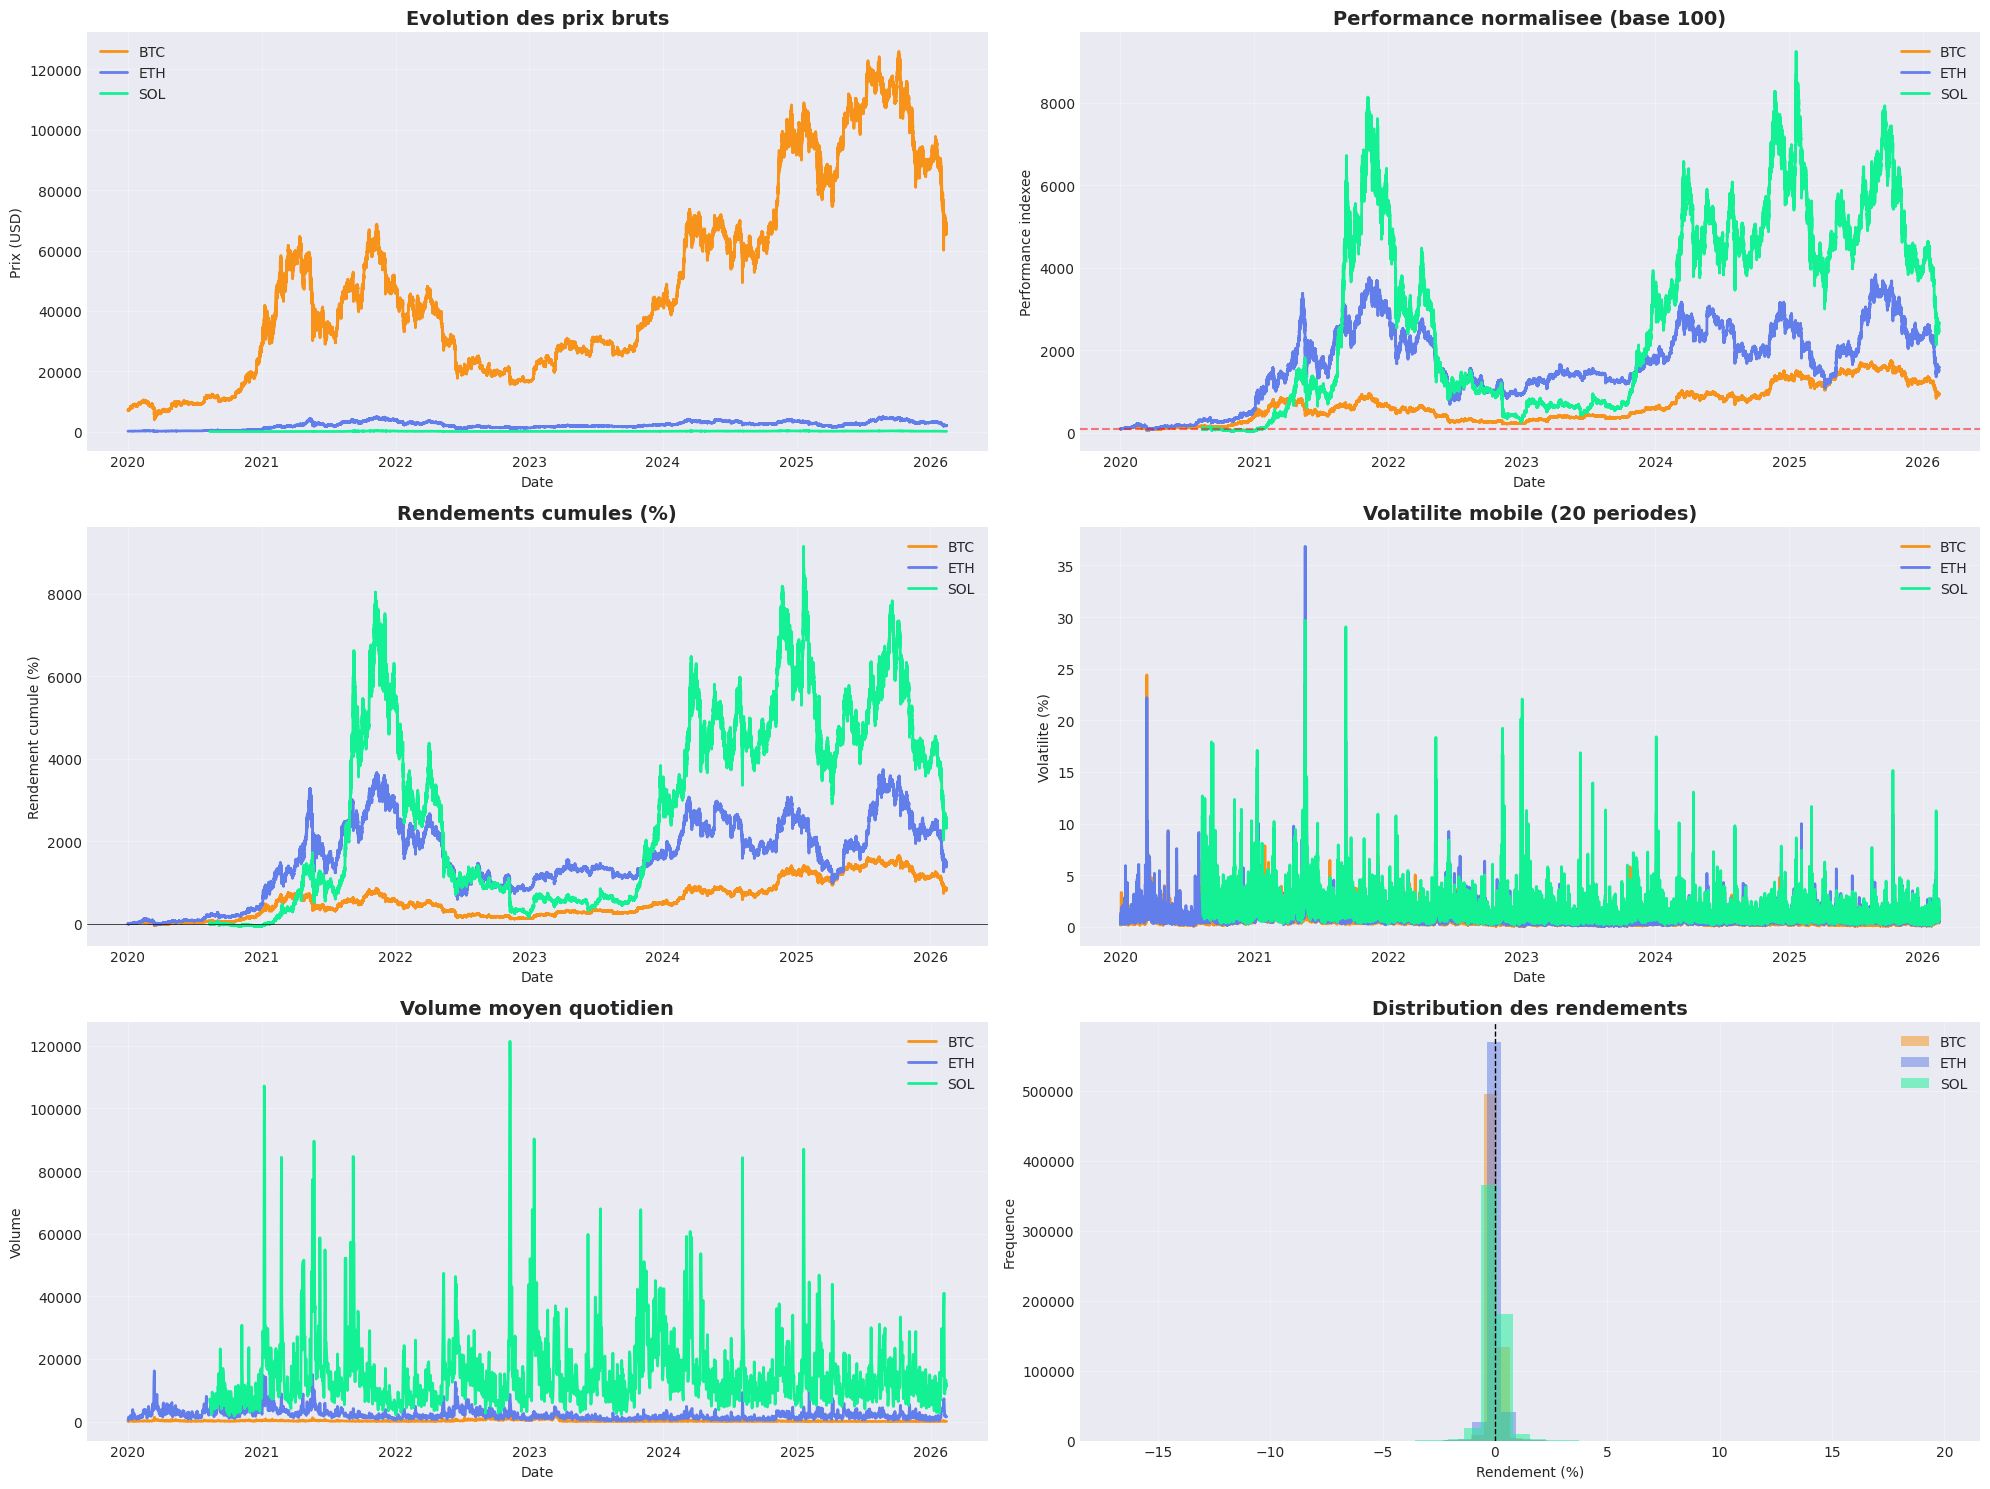

In [15]:
symbols = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
colors = ['#F7931A', '#627EEA', '#14F195']
labels = ['BTC', 'ETH', 'SOL']

fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# --- Prix bruts ---
ax = axes[0, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    ax.plot(data['timestamp'], data['close'], label=label, color=color, linewidth=2)
ax.set_title('Evolution des prix bruts', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Prix (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Performance normalisee ---
ax = axes[0, 1]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    normalized = (data['close'] / data['close'].iloc[0]) * 100
    ax.plot(data['timestamp'], normalized, label=label, color=color, linewidth=2)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5)
ax.set_title('Performance normalisee (base 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Performance indexee')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Rendements cumules ---
ax = axes[1, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    returns = data['close'].pct_change().fillna(0)
    cumulative = (1 + returns).cumprod() - 1
    ax.plot(data['timestamp'], cumulative * 100, label=label, color=color, linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Rendements cumules (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rendement cumule (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Volatilite mobile ---
ax = axes[1, 1]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    returns = data['close'].pct_change()
    rolling_vol = returns.rolling(window=20).std() * np.sqrt(20) * 100
    ax.plot(data['timestamp'], rolling_vol, label=label, color=color, linewidth=2)
ax.set_title('Volatilite mobile (20 periodes)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Volatilite (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Volume moyen quotidien ---
ax = axes[2, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    daily_vol = data.set_index('timestamp')['volume'].resample('D').mean()
    ax.plot(daily_vol.index, daily_vol.values, label=label, color=color, linewidth=2)
ax.set_title('Volume moyen quotidien', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Distribution des rendements ---
ax = axes[2, 1]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    returns = data['close'].pct_change() * 100
    ax.hist(returns.dropna(), bins=50, alpha=0.5, label=label, color=color)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_title('Distribution des rendements', fontsize=14, fontweight='bold')
ax.set_xlabel('Rendement (%)')
ax.set_ylabel('Frequence')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/comparison_btc_eth_sol.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6. Distributions et analyses techniques multi-crypto

On examine les distributions des prix, du RSI, la volatilite intraday par heure, et la matrice de correlations entre les variables numeriques.

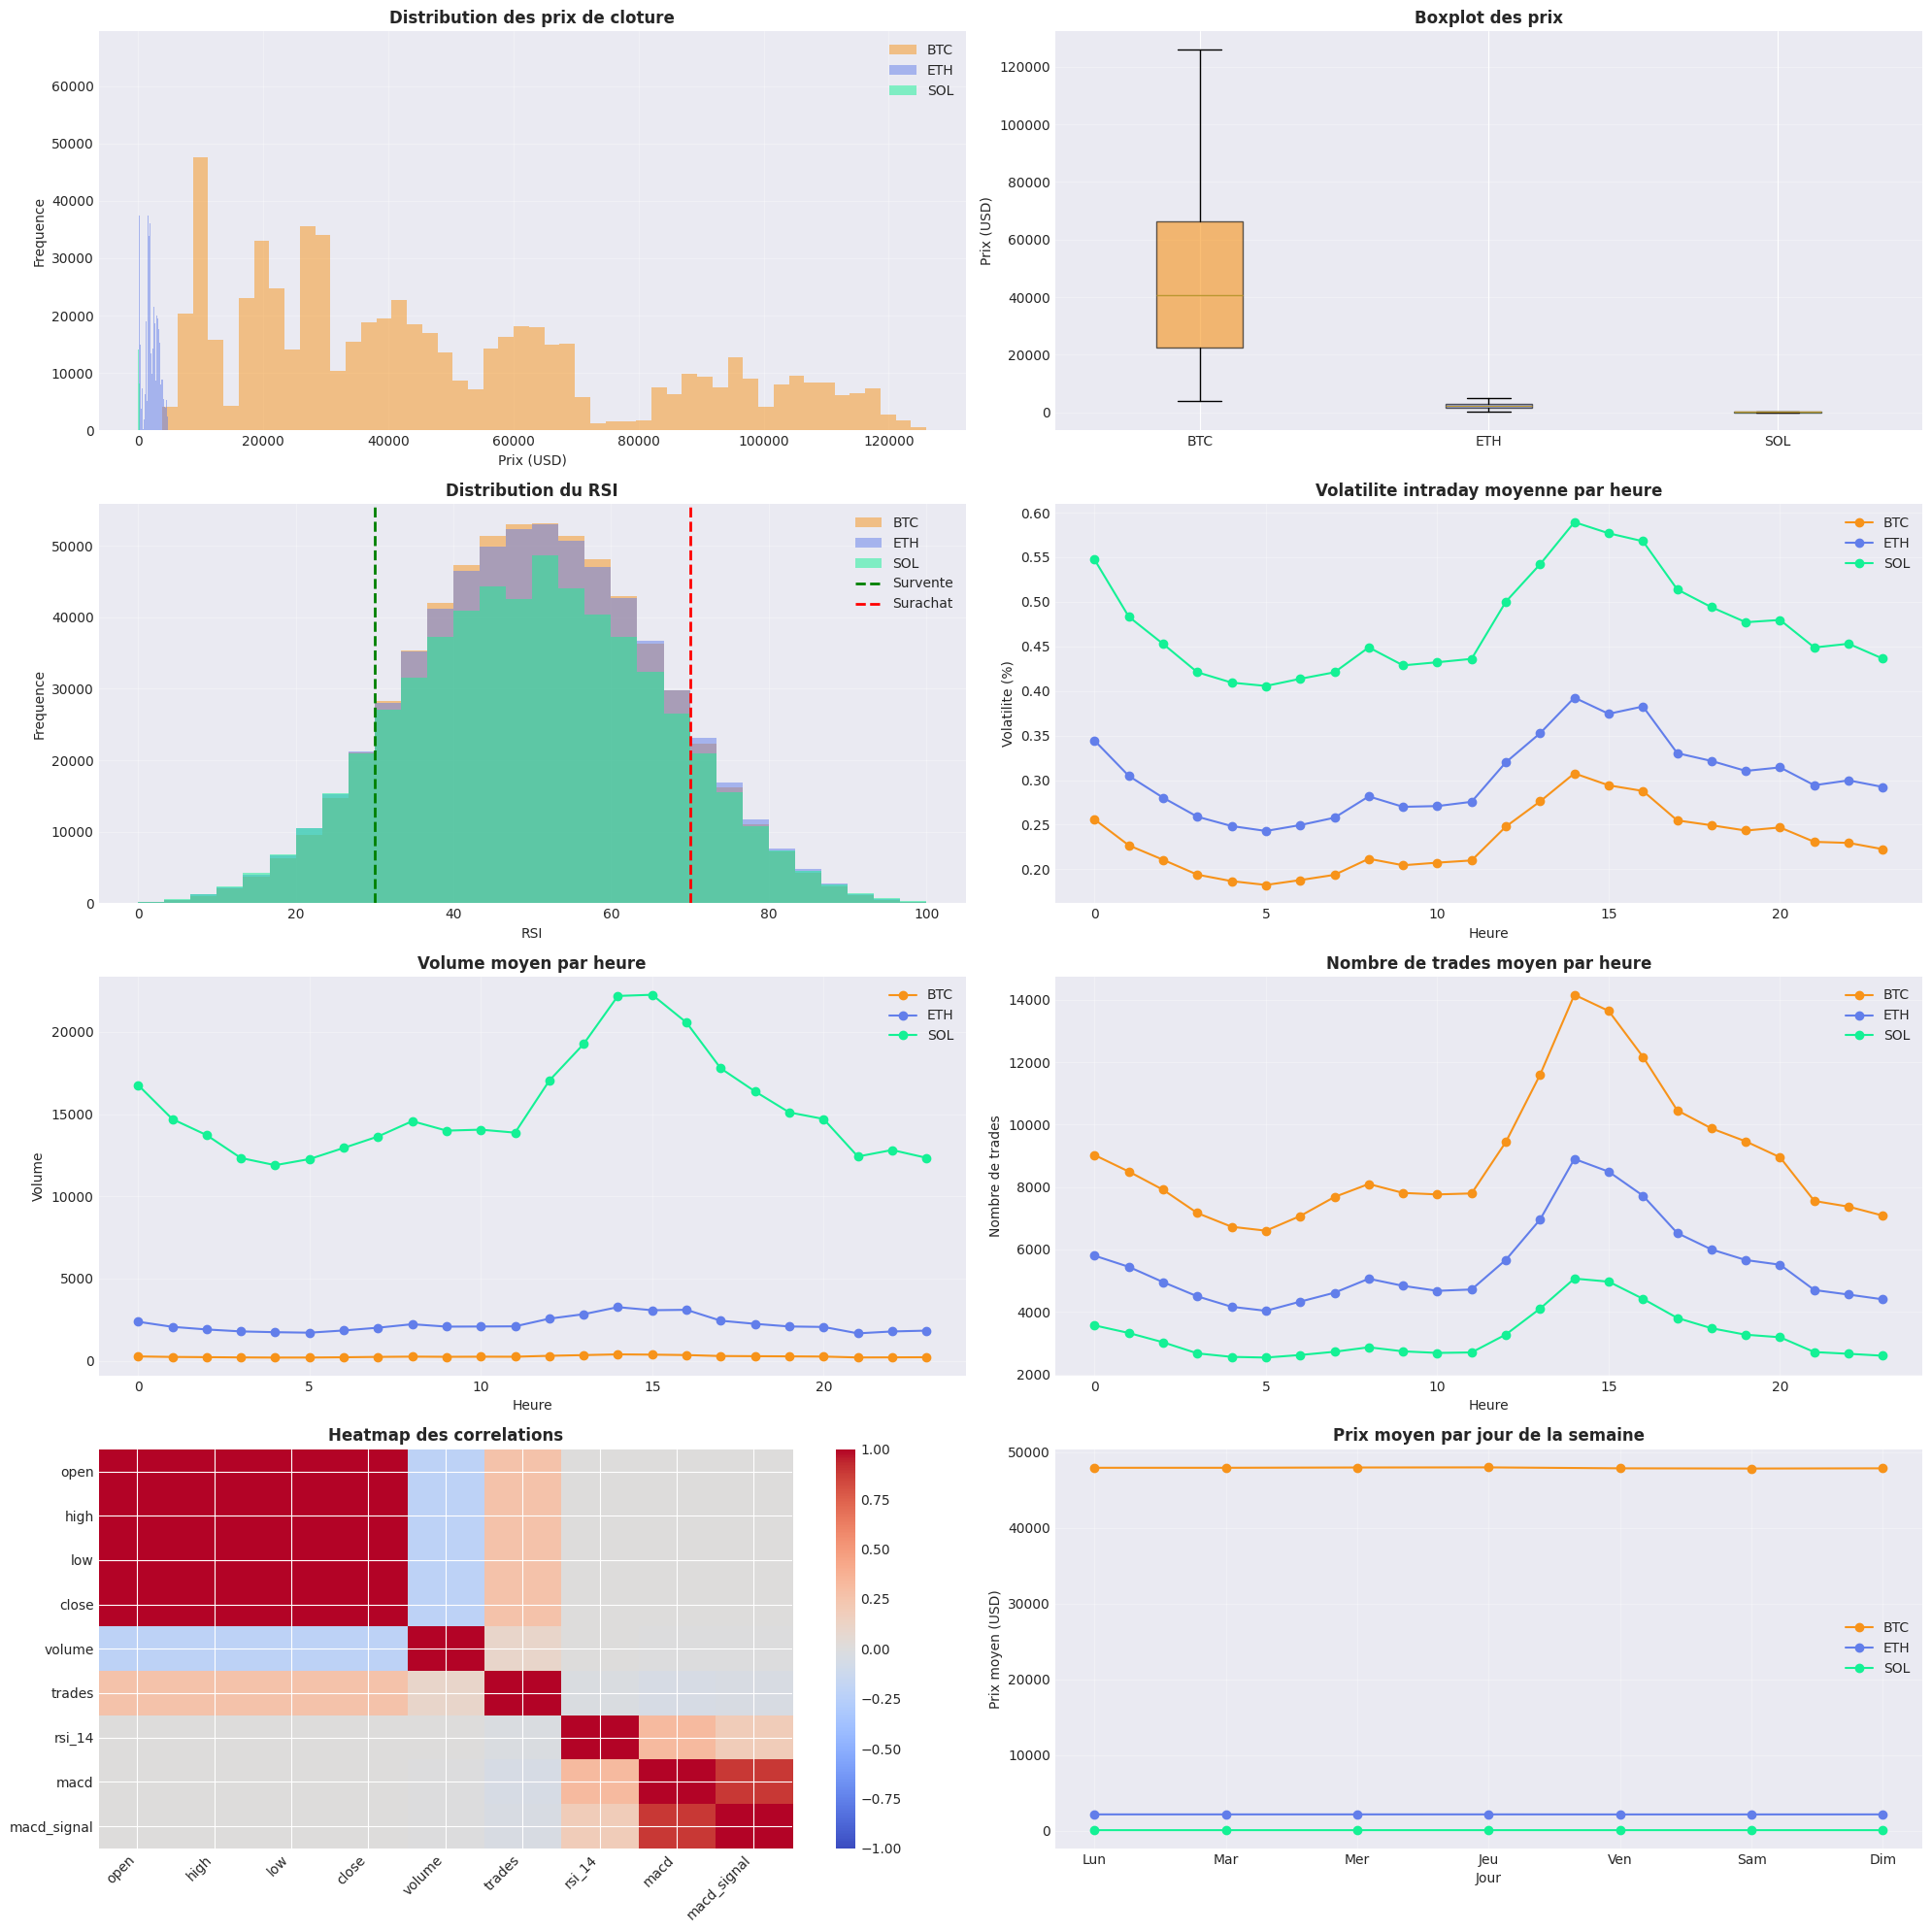

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

# Distribution des prix de cloture
ax = axes[0, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol]
    ax.hist(data['close'], bins=50, alpha=0.5, label=label, color=color)
ax.set_title('Distribution des prix de cloture', fontsize=12, fontweight='bold')
ax.set_xlabel('Prix (USD)')
ax.set_ylabel('Frequence')
ax.legend()
ax.grid(True, alpha=0.3)

# Boxplot des prix
ax = axes[0, 1]
box_data = [df[df['symbol'] == s]['close'].values for s in symbols]
bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_title('Boxplot des prix', fontsize=12, fontweight='bold')
ax.set_ylabel('Prix (USD)')
ax.grid(True, alpha=0.3, axis='y')

# Distribution du RSI
ax = axes[1, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol]
    ax.hist(data['rsi_14'], bins=30, alpha=0.5, label=label, color=color)
ax.axvline(x=30, color='green', linestyle='--', label='Survente', linewidth=2)
ax.axvline(x=70, color='red', linestyle='--', label='Surachat', linewidth=2)
ax.set_title('Distribution du RSI', fontsize=12, fontweight='bold')
ax.set_xlabel('RSI')
ax.set_ylabel('Frequence')
ax.legend()
ax.grid(True, alpha=0.3)

# Volatilite intraday par heure
ax = axes[1, 1]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].copy()
    data['vol_intraday'] = ((data['high'] - data['low']) / data['open']) * 100
    vol_hourly = data.groupby('hour')['vol_intraday'].mean()
    ax.plot(vol_hourly.index, vol_hourly.values, marker='o', label=label, color=color)
ax.set_title('Volatilite intraday moyenne par heure', fontsize=12, fontweight='bold')
ax.set_xlabel('Heure')
ax.set_ylabel('Volatilite (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# Volume par heure
ax = axes[2, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol]
    vol_hourly = data.groupby('hour')['volume'].mean()
    ax.plot(vol_hourly.index, vol_hourly.values, marker='o', label=label, color=color)
ax.set_title('Volume moyen par heure', fontsize=12, fontweight='bold')
ax.set_xlabel('Heure')
ax.set_ylabel('Volume')
ax.legend()
ax.grid(True, alpha=0.3)

# Trades par heure
ax = axes[2, 1]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol]
    trades_hourly = data.groupby('hour')['trades'].mean()
    ax.plot(trades_hourly.index, trades_hourly.values, marker='o', label=label, color=color)
ax.set_title('Nombre de trades moyen par heure', fontsize=12, fontweight='bold')
ax.set_xlabel('Heure')
ax.set_ylabel('Nombre de trades')
ax.legend()
ax.grid(True, alpha=0.3)

# Heatmap des correlations
ax = axes[3, 0]
corr_cols = ['open', 'high', 'low', 'close', 'volume', 'trades', 'rsi_14', 'macd', 'macd_signal']
corr_matrix = df[corr_cols].corr()
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha='right')
ax.set_yticklabels(corr_cols)
ax.set_title('Heatmap des correlations', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax)

# Prix moyen par jour de la semaine
ax = axes[3, 1]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol]
    daily_avg = data.groupby('day_of_week')['close'].mean().reindex(day_order)
    ax.plot(range(len(daily_avg)), daily_avg.values, marker='o', label=label, color=color)
ax.set_xticks(range(len(day_order)))
ax.set_xticklabels(['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])
ax.set_title('Prix moyen par jour de la semaine', fontsize=12, fontweight='bold')
ax.set_xlabel('Jour')
ax.set_ylabel('Prix moyen (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/analyse_technique_detaillee.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 7. Analyse technique detaillee : Bitcoin

On se concentre sur BTC pour examiner les indicateurs techniques en detail : moyennes mobiles, bandes de Bollinger, RSI et MACD.

In [ ]:
btc_data = df[df['symbol'] == 'BTCUSDT'].sort_values('timestamp').copy()

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Prix avec moyennes mobiles
ax = axes[0, 0]
ax.plot(btc_data['timestamp'], btc_data['close'], label='Close', linewidth=2, color='#2E86AB')
ax.plot(btc_data['timestamp'], btc_data['sma_20'], label='SMA 20', linewidth=1.5, linestyle='--', color='#A23B72')
ax.plot(btc_data['timestamp'], btc_data['ema_50'], label='EMA 50', linewidth=1.5, linestyle='--', color='#F18F01')
ax.set_title('BTC : Prix avec moyennes mobiles', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Prix (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bandes de Bollinger
ax = axes[0, 1]
ax.plot(btc_data['timestamp'], btc_data['close'], label='Close', linewidth=2, color='blue')
ax.plot(btc_data['timestamp'], btc_data['bb_upper'], label='BB Upper', linewidth=1, linestyle='--', color='red')
ax.plot(btc_data['timestamp'], btc_data['bb_middle'], label='BB Middle', linewidth=1, linestyle='--', color='gray')
ax.plot(btc_data['timestamp'], btc_data['bb_lower'], label='BB Lower', linewidth=1, linestyle='--', color='green')
ax.fill_between(btc_data['timestamp'], btc_data['bb_lower'], btc_data['bb_upper'], alpha=0.1, color='gray')
ax.set_title('BTC : Bandes de Bollinger', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Prix (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# RSI avec zones
ax = axes[1, 0]
ax.plot(btc_data['timestamp'], btc_data['rsi_14'], linewidth=2, color='purple')
ax.axhline(y=70, color='red', linestyle='--', label='Surachat', linewidth=2)
ax.axhline(y=30, color='green', linestyle='--', label='Survente', linewidth=2)
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax.fill_between(btc_data['timestamp'], 70, 100, alpha=0.1, color='red')
ax.fill_between(btc_data['timestamp'], 0, 30, alpha=0.1, color='green')
ax.set_title('BTC : RSI avec zones', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
ax.set_ylim(0, 100)
ax.legend()
ax.grid(True, alpha=0.3)

# MACD
ax = axes[1, 1]
ax.plot(btc_data['timestamp'], btc_data['macd'], label='MACD', linewidth=2, color='blue')
ax.plot(btc_data['timestamp'], btc_data['macd_signal'], label='Signal', linewidth=2, color='red')
macd_hist = btc_data['macd'] - btc_data['macd_signal']
colors_macd = ['green' if x > 0 else 'red' for x in macd_hist]
ax.bar(btc_data['timestamp'], macd_hist, alpha=0.3, color=colors_macd)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('BTC : MACD avec histogramme', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('MACD')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/btc_analyse_detaillee.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 8. Analyse des rendements et du risque

On calcule les statistiques des rendements pour evaluer le profil risque/rendement de chaque actif. Le skewness et le kurtosis renseignent sur la forme de la distribution (asymetrie et queues epaisses).

In [ ]:
returns_stats = []

for symbol in symbols:
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    returns = data['close'].pct_change() * 100

    stats = {
        'Symbol': symbol.replace('USDT', ''),
        'Rendement moyen (%)': round(returns.mean(), 4),
        'Rendement median (%)': round(returns.median(), 4),
        'Volatilite (%)': round(returns.std(), 4),
        'Rendement min (%)': round(returns.min(), 2),
        'Rendement max (%)': round(returns.max(), 2),
        'Skewness': round(returns.skew(), 4),
        'Kurtosis': round(returns.kurtosis(), 4),
        'Periodes positives': (returns > 0).sum(),
        'Periodes negatives': (returns < 0).sum(),
    }
    returns_stats.append(stats)

returns_df = pd.DataFrame(returns_stats)
returns_df

---
## 9. Correlations entre cryptomonnaies

On construit une matrice de correlation des prix de cloture pour mesurer a quel point les trois actifs evoluent ensemble.

In [ ]:
pivot_df = df.pivot_table(values='close', index='timestamp', columns='symbol')
crypto_corr = pivot_df.corr()

print("Correlations des prix de cloture :")
display(crypto_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(crypto_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlations entre cryptomonnaies (prix)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/exploratoire/correlation_cryptos.png', dpi=300, bbox_inches='tight')
plt.show()

On regarde aussi la correlation des **rendements** (plus pertinente que celle des prix car elle elimine le biais de tendance commune) :

In [ ]:
returns_pivot = pivot_df.pct_change().dropna()
returns_corr = returns_pivot.corr()

print("Correlations des rendements :")
display(returns_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(returns_corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlations entre cryptomonnaies (rendements)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---
## 10. Analyse des volumes

Le volume est un indicateur cle de la liquidite et de l'interet des participants du marche.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Volume total par crypto
ax = axes[0, 0]
volume_total = df.groupby('symbol')['volume'].sum().sort_values(ascending=False)
volume_total.index = volume_total.index.str.replace('USDT', '')
ax.bar(range(len(volume_total)), volume_total.values, color=colors)
ax.set_xticks(range(len(volume_total)))
ax.set_xticklabels(volume_total.index)
ax.set_title('Volume total par crypto', fontsize=12, fontweight='bold')
ax.set_ylabel('Volume total')
ax.grid(True, alpha=0.3, axis='y')

# Evolution du volume quotidien
ax = axes[0, 1]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp')
    daily_vol = data.set_index('timestamp')['volume'].resample('D').sum()
    ax.plot(daily_vol.index, daily_vol.values, label=label, color=color, linewidth=2)
ax.set_title('Evolution du volume quotidien', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.legend()
ax.grid(True, alpha=0.3)

# Distribution du volume (echelle log)
ax = axes[1, 0]
for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol]
    ax.hist(data['volume'], bins=50, alpha=0.5, label=label, color=color)
ax.set_title('Distribution du volume', fontsize=12, fontweight='bold')
ax.set_xlabel('Volume')
ax.set_ylabel('Frequence (echelle log)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Relation prix-volume pour BTC (colore par RSI)
ax = axes[1, 1]
btc = df[df['symbol'] == 'BTCUSDT']
scatter = ax.scatter(btc['volume'], btc['close'], c=btc['rsi_14'],
                     cmap='RdYlGn', alpha=0.5, s=20)
ax.set_title('BTC : relation prix-volume (colore par RSI)', fontsize=12, fontweight='bold')
ax.set_xlabel('Volume')
ax.set_ylabel('Prix (USD)')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='RSI')

plt.tight_layout()
plt.savefig('images/exploratoire/analyse_volumes.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 11. Nouveaux insights

On va au-dela de l'exploration classique pour identifier des patterns plus avances.

### 11.1 Regimes de volatilite

On segmente la volatilite en trois regimes (faible, moyenne, elevee) pour chaque crypto. Cela permet de voir dans quel etat du marche on se trouve le plus souvent et comment les rendements different selon le regime.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (symbol, color, label) in enumerate(zip(symbols, colors, labels)):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['returns'] = data['close'].pct_change() * 100
    data['rolling_vol'] = data['returns'].rolling(window=20).std()
    data = data.dropna(subset=['rolling_vol'])

    # Definir les regimes par quantiles
    q33 = data['rolling_vol'].quantile(0.33)
    q66 = data['rolling_vol'].quantile(0.66)
    data['regime'] = pd.cut(
        data['rolling_vol'],
        bins=[-np.inf, q33, q66, np.inf],
        labels=['Faible', 'Moyenne', 'Elevee']
    )

    ax = axes[idx]
    regime_colors = {'Faible': 'green', 'Moyenne': 'orange', 'Elevee': 'red'}
    for regime, rc in regime_colors.items():
        subset = data[data['regime'] == regime]
        ax.scatter(subset['timestamp'], subset['close'], c=rc, alpha=0.4, s=5, label=regime)

    ax.set_title(f'{label} : regimes de volatilite', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Prix (USD)')
    ax.legend(title='Volatilite')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/regimes_volatilite.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Statistiques par regime
print("Rendement moyen par regime de volatilite :")
print()

for symbol, label in zip(symbols, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['returns'] = data['close'].pct_change() * 100
    data['rolling_vol'] = data['returns'].rolling(window=20).std()
    data = data.dropna(subset=['rolling_vol'])

    q33 = data['rolling_vol'].quantile(0.33)
    q66 = data['rolling_vol'].quantile(0.66)
    data['regime'] = pd.cut(
        data['rolling_vol'],
        bins=[-np.inf, q33, q66, np.inf],
        labels=['Faible', 'Moyenne', 'Elevee']
    )

    regime_stats = data.groupby('regime', observed=True)['returns'].agg(['mean', 'std', 'count'])
    regime_stats.columns = ['Rendement moy. (%)', 'Volatilite (%)', 'Nb periodes']
    print(f"--- {label} ---")
    display(regime_stats.round(4))
    print()

### 11.2 Divergences volume-prix

Une divergence volume-prix se produit quand le prix monte mais que le volume baisse (ou inversement). C'est un signal classique d'essoufflement de tendance.

On calcule la correlation mobile (rolling) entre les variations de prix et de volume. Quand cette correlation devient fortement negative, il y a divergence.

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)

for idx, (symbol, color, label) in enumerate(zip(symbols, colors, labels)):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['price_change'] = data['close'].pct_change()
    data['volume_change'] = data['volume'].pct_change()
    data['pv_corr'] = data['price_change'].rolling(window=30).corr(data['volume_change'])

    ax = axes[idx]
    ax.plot(data['timestamp'], data['pv_corr'], color=color, linewidth=1.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axhline(y=-0.3, color='red', linestyle='--', alpha=0.5, label='Seuil divergence')
    ax.fill_between(data['timestamp'], data['pv_corr'], -0.3,
                    where=data['pv_corr'] < -0.3, alpha=0.3, color='red')
    ax.set_title(f'{label} : correlation mobile prix-volume (30 periodes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Correlation')
    ax.set_ylim(-1, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('images/exploratoire/divergences_volume_prix.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.3 Beta rolling : sensibilite de ETH et SOL par rapport a BTC

Le beta mesure la sensibilite d'un actif par rapport au marche (ici BTC). Un beta > 1 signifie que l'actif amplifie les mouvements de BTC. Un beta < 1 signifie qu'il les amortit.

On calcule un beta mobile sur 50 periodes pour voir comment cette relation evolue dans le temps.

In [ ]:
btc_returns = df[df['symbol'] == 'BTCUSDT'].sort_values('timestamp').set_index('timestamp')['close'].pct_change()

fig, ax = plt.subplots(figsize=(18, 6))

for symbol, color, label in [('ETHUSDT', '#627EEA', 'ETH'), ('SOLUSDT', '#14F195', 'SOL')]:
    asset_returns = df[df['symbol'] == symbol].sort_values('timestamp').set_index('timestamp')['close'].pct_change()

    # Aligner les index
    aligned = pd.DataFrame({'btc': btc_returns, 'asset': asset_returns}).dropna()

    # Beta rolling = cov(asset, btc) / var(btc)
    rolling_cov = aligned['asset'].rolling(50).cov(aligned['btc'])
    rolling_var = aligned['btc'].rolling(50).var()
    rolling_beta = rolling_cov / rolling_var

    ax.plot(aligned.index, rolling_beta, label=f'{label} beta vs BTC', color=color, linewidth=2)

ax.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Beta = 1')
ax.set_title('Beta rolling (50 periodes) par rapport a BTC', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Beta')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/beta_rolling.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.4 Largeur des bandes de Bollinger : mesure de compression

Quand les bandes de Bollinger se resserrent (faible largeur), cela indique une phase de compression de la volatilite. Historiquement, ces phases precedent souvent un mouvement de prix important (dans un sens ou l'autre). On appelle cela un "squeeze".

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)

for idx, (symbol, color, label) in enumerate(zip(symbols, colors, labels)):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['bb_width'] = (data['bb_upper'] - data['bb_lower']) / data['bb_middle'] * 100

    ax = axes[idx]
    ax.plot(data['timestamp'], data['bb_width'], color=color, linewidth=1.5)

    # Identifier les squeezes (percentile 10)
    squeeze_threshold = data['bb_width'].quantile(0.10)
    squeeze = data[data['bb_width'] < squeeze_threshold]
    ax.scatter(squeeze['timestamp'], squeeze['bb_width'], color='red', s=15, zorder=5, label='Squeeze')
    ax.axhline(y=squeeze_threshold, color='red', linestyle='--', alpha=0.5)

    ax.set_title(f'{label} : largeur des bandes de Bollinger (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Largeur (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('images/exploratoire/bollinger_squeeze.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.5 Profil de rendement par session de marche

Le marche crypto est ouvert 24h/24, mais les sessions traditionnelles (Asie, Europe, Amerique) influencent l'activite. On segmente la journee en trois sessions :
- **Asie** : 00h - 08h UTC
- **Europe** : 08h - 16h UTC
- **Amerique** : 16h - 00h UTC

In [ ]:
def assign_session(hour):
    if 0 <= hour < 8:
        return 'Asie (00-08 UTC)'
    elif 8 <= hour < 16:
        return 'Europe (08-16 UTC)'
    else:
        return 'Amerique (16-00 UTC)'

df['session'] = df['hour'].apply(assign_session)

session_stats = []
for symbol, label in zip(symbols, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['returns'] = data['close'].pct_change() * 100

    for session in ['Asie (00-08 UTC)', 'Europe (08-16 UTC)', 'Amerique (16-00 UTC)']:
        subset = data[data['session'] == session]['returns'].dropna()
        session_stats.append({
            'Crypto': label,
            'Session': session,
            'Rendement moy. (%)': round(subset.mean(), 4),
            'Volatilite (%)': round(subset.std(), 4),
            'Volume moyen': round(data[data['session'] == session]['volume'].mean(), 2),
            'Nb trades moyen': round(data[data['session'] == session]['trades'].mean(), 0),
        })

session_df = pd.DataFrame(session_stats)
session_df

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

session_order = ['Asie (00-08 UTC)', 'Europe (08-16 UTC)', 'Amerique (16-00 UTC)']
bar_colors = ['#E8575A', '#5B8DBE', '#6BBF6B']

for idx, (symbol, label) in enumerate(zip(symbols, labels)):
    subset = session_df[session_df['Crypto'] == label].set_index('Session').reindex(session_order)
    ax = axes[idx]
    ax.bar(range(3), subset['Volatilite (%)'], color=bar_colors, alpha=0.8)
    ax.set_xticks(range(3))
    ax.set_xticklabels(['Asie', 'Europe', 'Amerique'])
    ax.set_title(f'{label} : volatilite par session', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatilite (%)')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/exploratoire/sessions_trading.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.6 Drawdown dans le temps

Le drawdown mesure la perte par rapport au plus haut historique atteint. C'est une metrique essentielle pour evaluer le risque reel subi par un investisseur.

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))

for symbol, color, label in zip(symbols, colors, labels):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['cummax'] = data['close'].cummax()
    data['drawdown'] = (data['close'] / data['cummax'] - 1) * 100
    ax.plot(data['timestamp'], data['drawdown'], label=label, color=color, linewidth=1.5)
    ax.fill_between(data['timestamp'], data['drawdown'], 0, alpha=0.1, color=color)

ax.set_title('Drawdown par rapport au plus haut historique', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/drawdown.png', dpi=300, bbox_inches='tight')
plt.show()

### 11.7 Ratio volume/trades : taille moyenne des ordres

Ce ratio indique la taille moyenne des ordres. Un ratio eleve suggere que de gros acteurs ("whales") interviennent sur le marche. Un ratio faible indique une activite de detail.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (symbol, color, label) in enumerate(zip(symbols, colors, labels)):
    data = df[df['symbol'] == symbol].sort_values('timestamp').copy()
    data['avg_trade_size'] = data['volume'] / data['trades']
    rolling_avg = data['avg_trade_size'].rolling(50).mean()

    ax = axes[idx]
    ax.plot(data['timestamp'], data['avg_trade_size'], alpha=0.2, color=color)
    ax.plot(data['timestamp'], rolling_avg, color=color, linewidth=2, label='Moyenne mobile (50)')
    ax.set_title(f'{label} : taille moyenne des ordres', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume / Trades')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/exploratoire/avg_trade_size.png', dpi=300, bbox_inches='tight')
plt.show()